<h1>LSTM Anomaly Detection for 2022-2023</h1>
Using data from 2022-20223, we try to plot our reconstruction error on 5 identified critical tags, so that we may feed this anomaly detection into our Power BI

In [1]:
#importing libraries and dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load the data frame
df=pd.read_excel('OracleTagsFinal.xlsx',sheet_name='Sheet1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918721 entries, 0 to 918720
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    918721 non-null  datetime64[ns]
 1   Feed19  918721 non-null  object        
 2   SysP    918721 non-null  object        
 3   ART1    918721 non-null  object        
 4   ART2    918721 non-null  object        
 5   ART3    918721 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 42.1+ MB


In [3]:
#change the data types
def change_types(df):
    for col in df.columns:
        if df[col].dtypes=='object':
            df[col]=df[col].apply(pd.to_numeric,errors='coerce')
        
        else:
            pass
    return df

#change the data types
df=change_types(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918721 entries, 0 to 918720
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    918721 non-null  datetime64[ns]
 1   Feed19  904774 non-null  float64       
 2   SysP    918689 non-null  float64       
 3   ART1    918683 non-null  float64       
 4   ART2    918683 non-null  float64       
 5   ART3    918683 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 42.1 MB


In [4]:
#fill the null with 0
df=df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918721 entries, 0 to 918720
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    918721 non-null  datetime64[ns]
 1   Feed19  918721 non-null  float64       
 2   SysP    918721 non-null  float64       
 3   ART1    918721 non-null  float64       
 4   ART2    918721 non-null  float64       
 5   ART3    918721 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 42.1 MB


In [28]:
#now,let's separate the dataframe
df19 = pd.DataFrame({'Date':df['Date'],'Feed19':df['Feed19']})
dfP= pd.DataFrame({'Date':df['Date'],'SysP':df['SysP']})
df1=pd.DataFrame({'Date':df['Date'],'ART1':df['ART1']})
df2=pd.DataFrame({'Date':df['Date'],'ART2':df['ART2']})
df3=pd.DataFrame({'Date':df['Date'],'ART3':df['ART3']})

In [6]:
#let's scale our dataframe and feed it to sequences

#build our sequence function


seq_size=60


def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)


#call minmaxscaler
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
df19.loc[:, 'Feed19'] = scaler.fit_transform(df19[['Feed19']])
dfP.loc[:, 'SysP'] = scaler.fit_transform(dfP[['SysP']])
df1.loc[:, 'ART1'] = scaler.fit_transform(df1[['ART1']])
df2.loc[:, 'ART2'] = scaler.fit_transform(df2[['ART2']])
df3.loc[:, 'ART3'] = scaler.fit_transform(df3[['ART3']])


#then put everything in a sequence using the sequence function
#feed19
X19,y19=to_sequences(df19[['Feed19']],df19[['Feed19']],seq_size)


#sysP
XP,yP=to_sequences(dfP[['SysP']],dfP[['SysP']],seq_size)

#ART1
X1,y1=to_sequences(df1[['ART1']],df1[['ART1']],seq_size)


#ART2
X2,y2=to_sequences(df2[['ART2']],df2[['ART2']],seq_size)


#ART3
X3,y3=to_sequences(df3[['ART3']],df3[['ART3']],seq_size)

print(XP.shape)
print(X19.shape)

(918661, 60, 1)
(918661, 60, 1)


In [7]:
#let's feed our data to our model to get the reconstruction error
from tensorflow.keras.models import load_model

#call our model first
model19=load_model("Feed19model")
modelP=load_model("SysPmodel")
model1=load_model("ART1model")
model2=load_model("ART2model")
model3=load_model("ART3model")


#push our data to predict
pred19 = model19.predict(X19)
predP =modelP.predict(XP)
pred1 =model1.predict(X1)
pred2 = model2. predict(X2)
pred3 =model3.predict(X3)

28709/28709 [==============================] - 571s 20ms/step


In [15]:
#get the mae
mae19=np.std(np.abs(pred19-X19),axis=1)
maeP=np.std(np.abs(predP-XP),axis=1)
mae1=np.std(np.abs(pred1-X1),axis=1)
mae2=np.std(np.abs(pred2-X2),axis=1)
mae3=np.std(np.abs(pred3-X3),axis=1)

Text(0.5, 1.0, 'Anomaly Dectection Graph for Feed19')

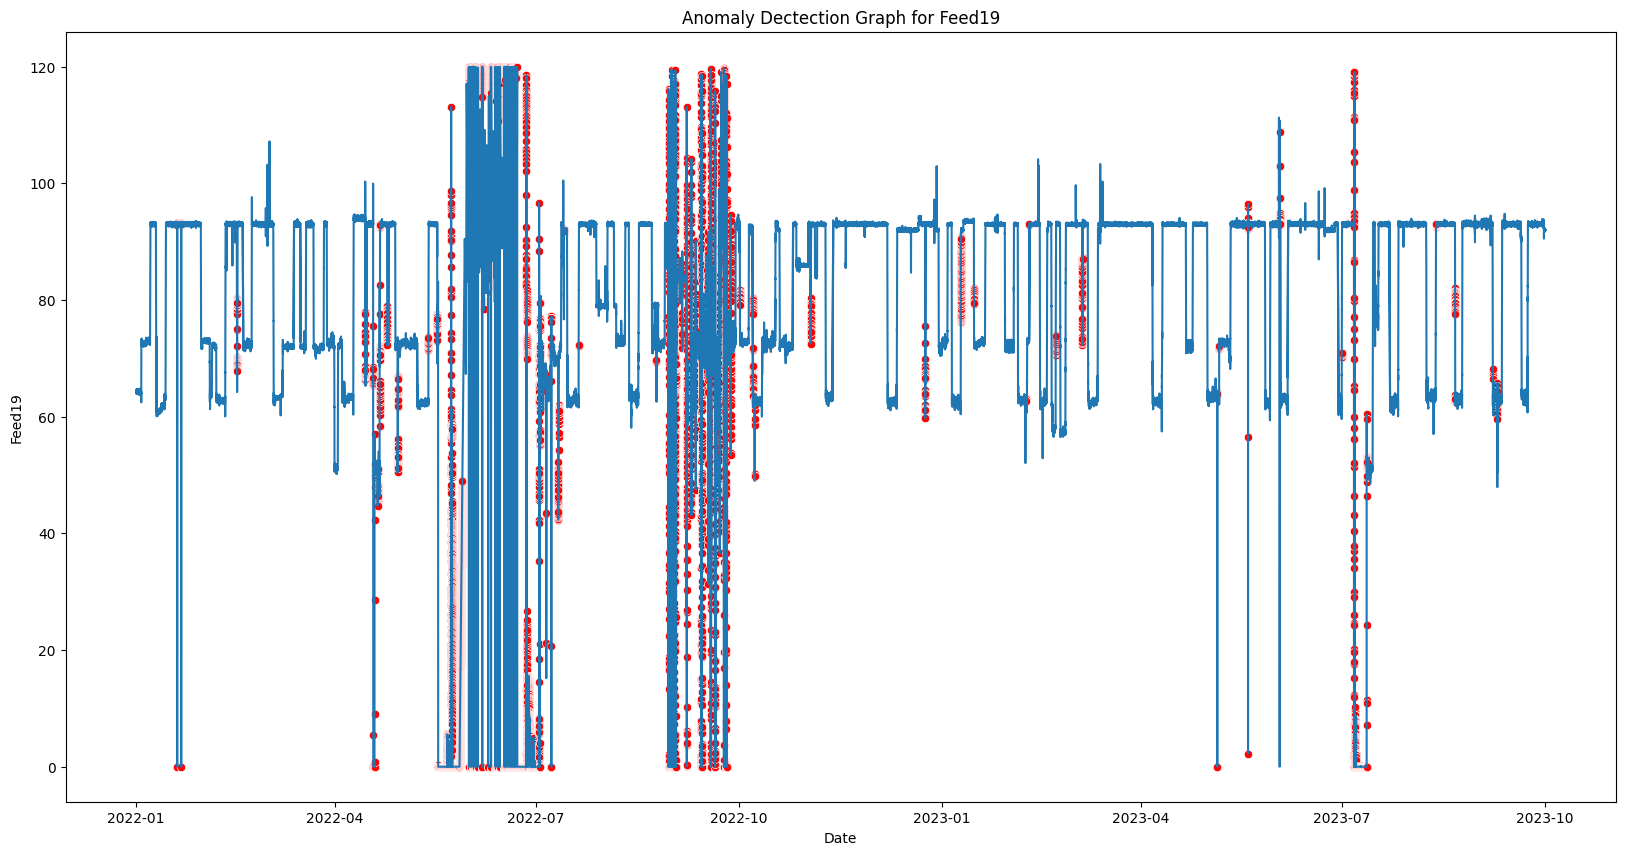

In [50]:
#create a new dataframe

dfn19 = pd.DataFrame(df19[seq_size:])
dfn19['mae']=mae19
dfn19['max_mae']=0.03
dfn19['anomaly']=dfn19['mae']>dfn19['max_mae']

anomalies19 = dfn19.loc[dfn19['anomaly']==True]

plt.figure(figsize=(20,10))

#plot anomalies and current data
sns.lineplot(x=dfn19['Date'],y=dfn19['Feed19'])
sns.scatterplot(x=dfn19['Date'],y=anomalies19['Feed19'],color='r')

plt.title('Anomaly Dectection Graph for Feed19')

Text(0.5, 1.0, 'Anomaly Dectection Graph for System Pressure')

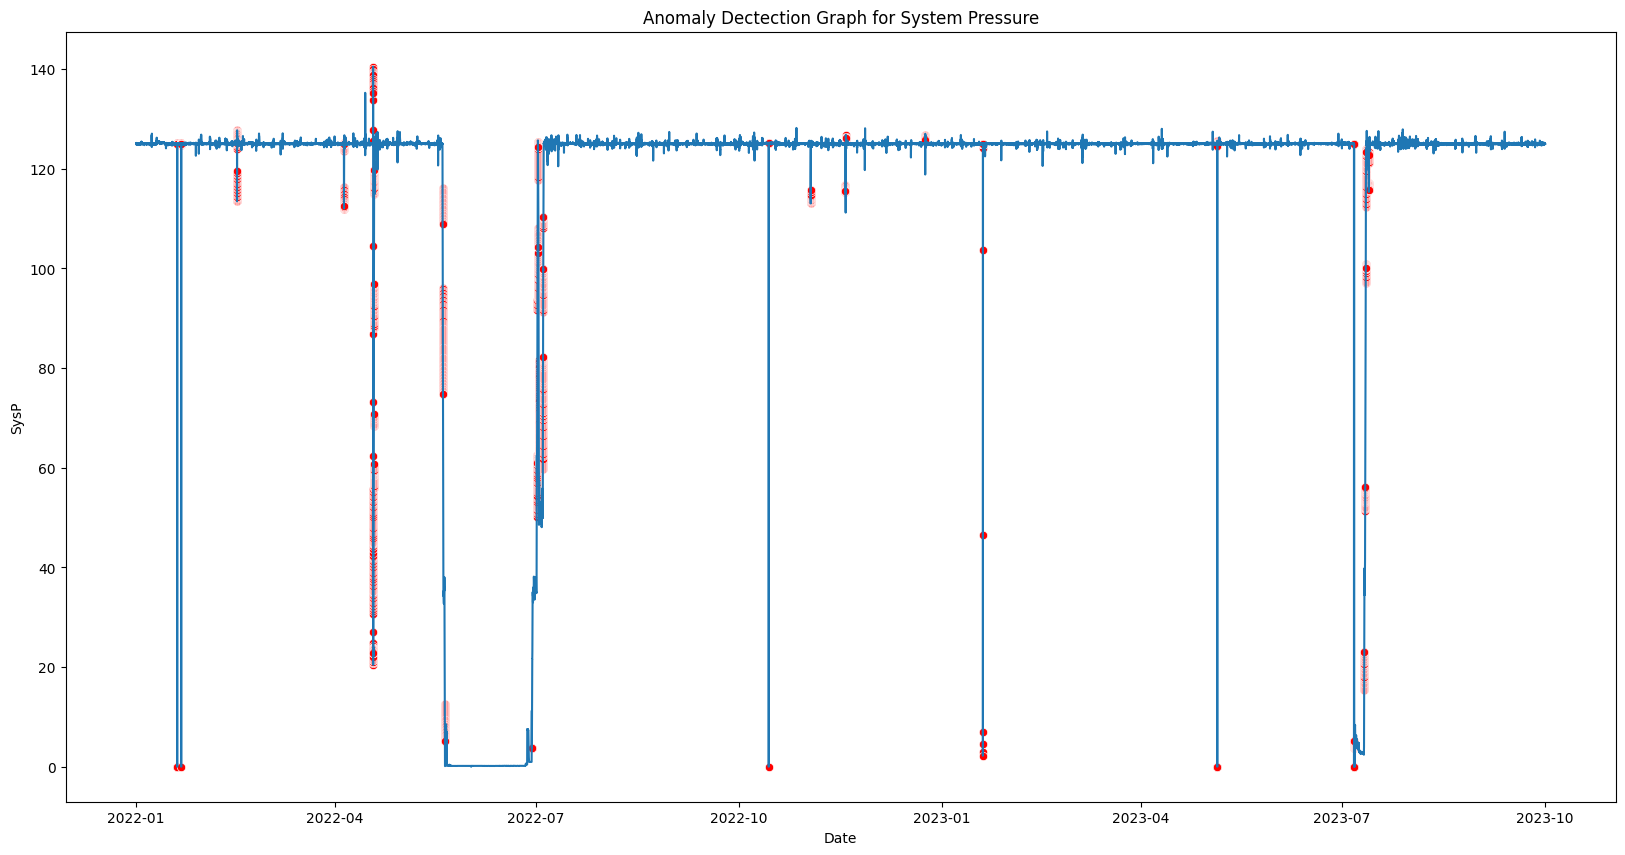

In [51]:
#for system pressure

dfnP = pd.DataFrame(dfP[seq_size:])
dfnP['mae']=maeP
dfnP['max_mae']=0.02
dfnP['anomaly']=dfnP['mae']>dfnP['max_mae']


anomaliesP = dfnP.loc[dfnP['anomaly']==True]

plt.figure(figsize=(20,10))

#plot anomalies and current data
sns.lineplot(x=dfnP['Date'],y=dfnP['SysP'])
sns.scatterplot(x=dfnP['Date'],y=anomaliesP['SysP'],color='r')

plt.title('Anomaly Dectection Graph for System Pressure')

Text(0.5, 1.0, 'Anomaly Dectection Graph for R1901 ART')

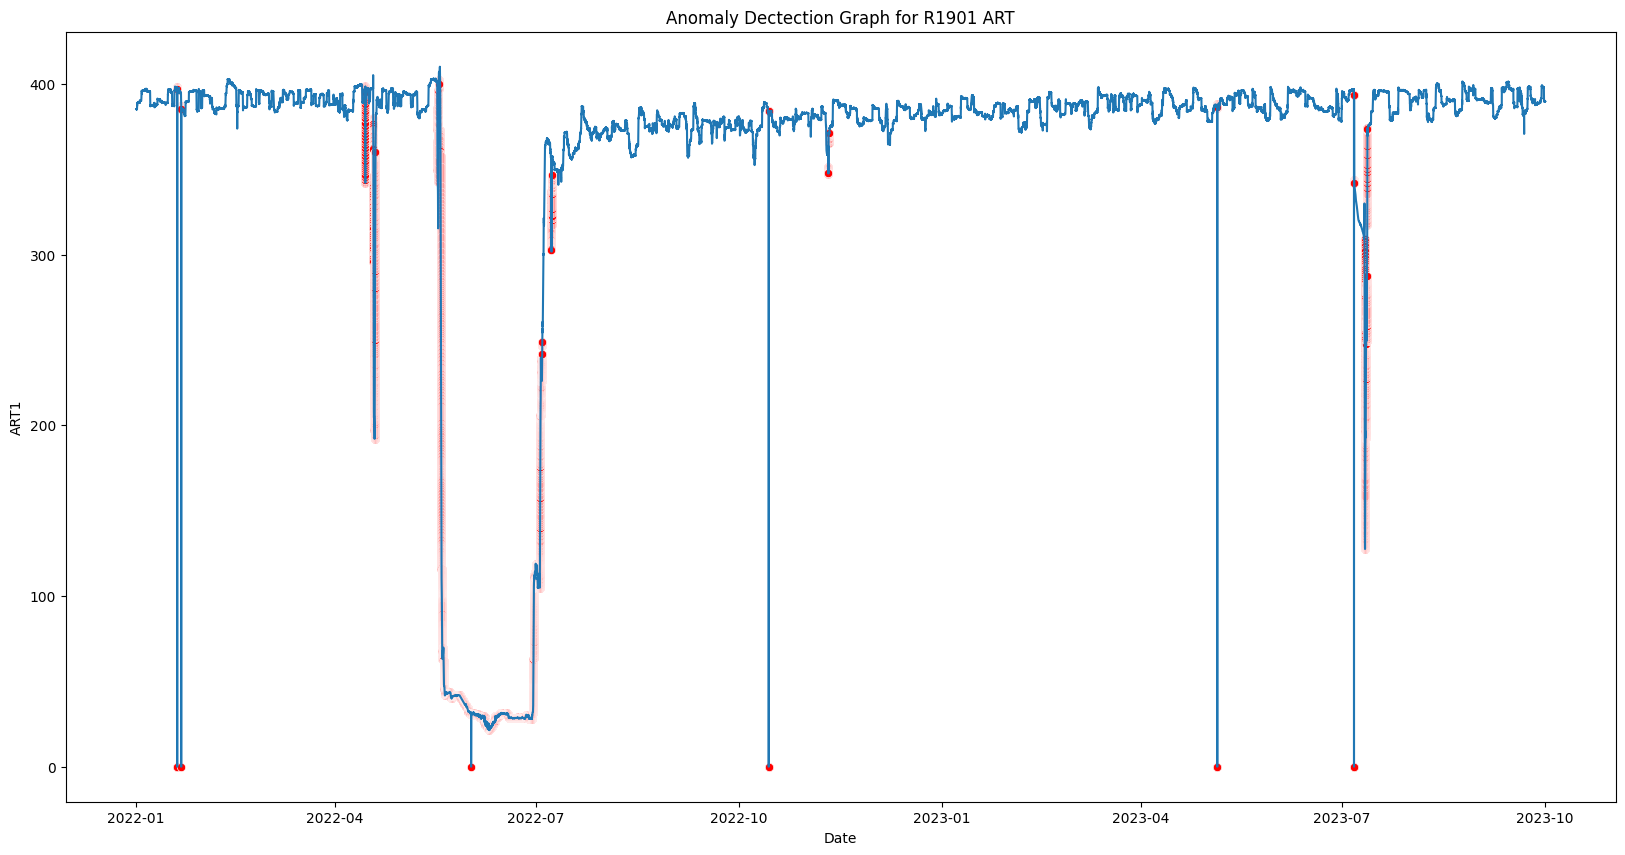

In [52]:
#for ART 1

dfn1 = pd.DataFrame(df1[seq_size:])
dfn1['mae']=mae1
dfn1['max_mae']=0.01
dfn1['anomaly']=dfn1['mae']>dfn1['max_mae']


anomalies1 = dfn1.loc[dfn1['anomaly']==True]

plt.figure(figsize=(20,10))

#plot anomalies and current data
sns.lineplot(x=dfn1['Date'],y=dfn1['ART1'])
sns.scatterplot(x=dfn1['Date'],y=anomalies1['ART1'],color='r')

plt.title('Anomaly Dectection Graph for R1901 ART')

Text(0.5, 1.0, 'Anomaly Dectection Graph for R1902 ART')

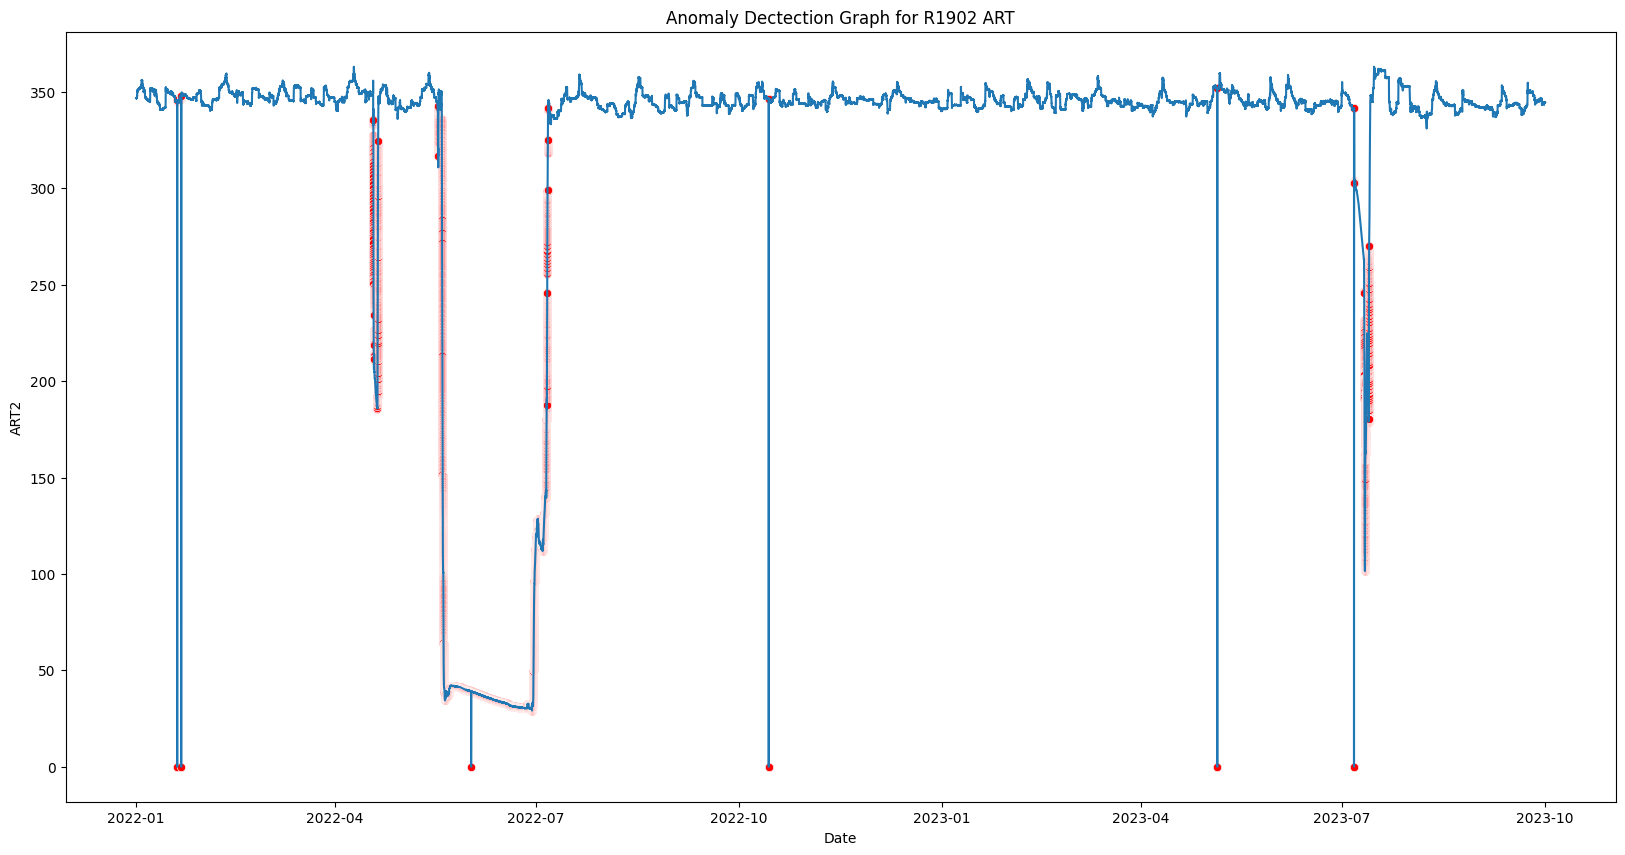

In [53]:
#for ART2
dfn2 = pd.DataFrame(df2[seq_size:])
dfn2['mae']=mae2
dfn2['max_mae']=0.01
dfn2['anomaly']=dfn2['mae']>dfn2['max_mae']


anomalies2 = dfn2.loc[dfn2['anomaly']==True]

plt.figure(figsize=(20,10))

#plot anomalies and current data
sns.lineplot(x=dfn2['Date'],y=dfn2['ART2'])
sns.scatterplot(x=dfn2['Date'],y=anomalies2['ART2'],color='r')

plt.title('Anomaly Dectection Graph for R1902 ART')

Text(0.5, 1.0, 'Anomaly Dectection Graph for R1903 ART')

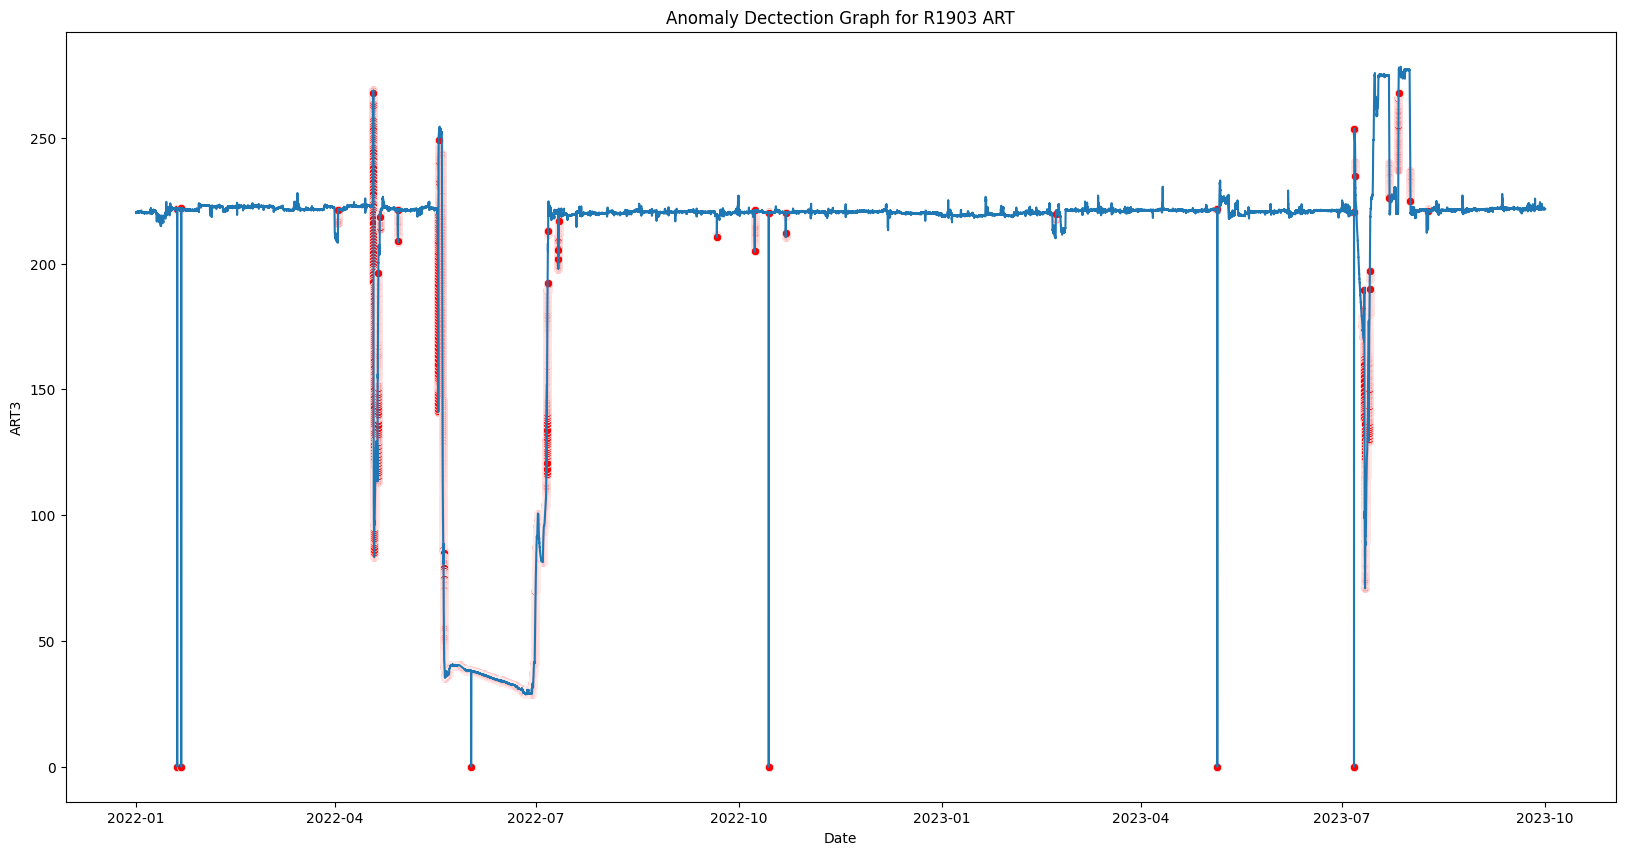

In [55]:
#for ART 3
dfn3 = pd.DataFrame(df3[seq_size:])
dfn3['mae']=mae3
dfn3['max_mae']=0.01
dfn3['anomaly']=dfn3['mae']>dfn3['max_mae']


anomalies3 = dfn3.loc[dfn3['anomaly']==True]

plt.figure(figsize=(20,10))

#plot anomalies and current data
sns.lineplot(x=dfn3['Date'],y=dfn3['ART3'])
sns.scatterplot(x=dfn3['Date'],y=anomalies3['ART3'],color='r')

plt.title('Anomaly Dectection Graph for R1903 ART')

In [56]:
#all data to excel
dfn19.to_excel('Feed19LSTM.xlsx',index=False)
dfnP.to_excel('SysPLSTM.xlsx',index=False)
dfn1.to_excel('ART1LSTM.xlsx',index=False)
dfn2.to_excel('ART2LSTM.xlsx',index=False)
dfn3.to_excel('ART3LSTM.xlsx',index=False)

In [49]:
dfn19

,Date,Feed19,mae,max_mae,anomaly
60,2022-01-01 01:00:00,17881.098767,0.002609,0.03,False
61,2022-01-01 01:01:00,17884.281128,0.002466,0.03,False
62,2022-01-01 01:02:00,17869.097506,0.002330,0.03,False
63,2022-01-01 01:03:00,17872.899781,0.002244,0.03,False
64,2022-01-01 01:04:00,17851.920397,0.002176,0.03,False
...,...,...,...,...,...
918716,2023-09-30 23:56:00,25605.830038,0.000681,0.03,False
918717,2023-09-30 23:57:00,25615.871779,0.000691,0.03,False
918718,2023-09-30 23:58:00,25605.573157,0.000698,0.03,False
918719,2023-09-30 23:59:00,25592.514647,0.000696,0.03,False
